<a href="https://colab.research.google.com/github/JesseOtradovec/DS-Unit-2-Regression-Classification/blob/master/Otradovecof_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)
df=df.drop_duplicates()
#df.SALE_PRICE=df.SALE_PRICE.replace(0,np.nan)
#df.YEAR_BUILT=df.YEAR_BUILT.replace(0,np.nan)
#df=df.replace(0,np.nan)
#m

In [4]:
mask=((df["BUILDING_CLASS_CATEGORY"]=='01 ONE FAMILY DWELLINGS')&
      (df['SALE_PRICE']>100000)&
      (df['SALE_PRICE']<2000000))
df=df[mask]
df.BOROUGH=df.BOROUGH.astype(str)
df.ZIP_CODE=df.ZIP_CODE.astype(str)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [5]:
df.SALE_DATE=pd.to_datetime(df.SALE_DATE, infer_datetime_format=True)
df.SALE_DATE.describe()

count                    3148
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [6]:
train = df[df.SALE_DATE.dt.month<4]
from sklearn.model_selection import train_test_split
train, validate = train_test_split(train,train_size=.5, random_state=42)
test= df[df.SALE_DATE.dt.month==4]
train.shape, validate.shape, test.shape

((1252, 21), (1253, 21), (643, 21))

In [7]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,1252,1,01 ONE FAMILY DWELLINGS,1252,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,1252,2,1,1237,NaN,NaN
BOROUGH,1252,5,4,595,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,1252,11,A1,452,NaN,NaN
BUILDING_CLASS_AT_PRESENT,1252,13,A1,452,NaN,NaN
SALE_DATE,1252,65,2019-01-31 00:00:00,41,2019-01-01 00:00:00,2019-03-29 00:00:00
ZIP_CODE,1252,114,10312.0,60,NaN,NaN
NEIGHBORHOOD,1252,164,FLUSHING-NORTH,37,NaN,NaN
LAND_SQUARE_FEET,1252,533,"4,000",131,NaN,NaN


In [8]:
train.TAX_CLASS_AT_PRESENT.value_counts(normalize=True,dropna=False)

1     0.988019
1D    0.011981
Name: TAX_CLASS_AT_PRESENT, dtype: float64

In [9]:
train.groupby('TAX_CLASS_AT_PRESENT').SALE_PRICE.describe()

,count,mean,std,min,25%,50%,75%,max
TAX_CLASS_AT_PRESENT,,,,,,,,
1,1237.0,629881.399353,293446.408712,105000.0,450000.0,565000.0,760000.0,1955000.0
1D,15.0,370940.000000,126733.115528,110000.0,288500.0,390000.0,445000.0,614000.0


In [10]:
train.profile_report()


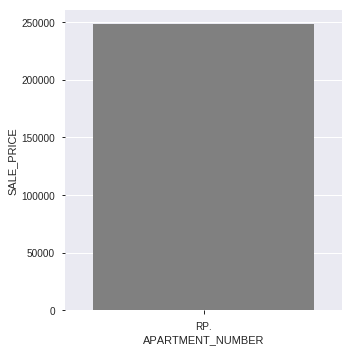

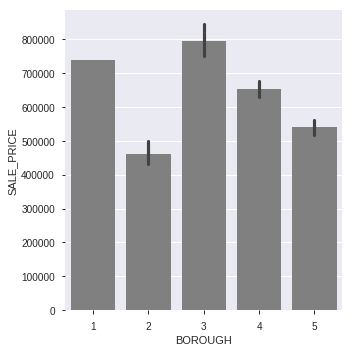

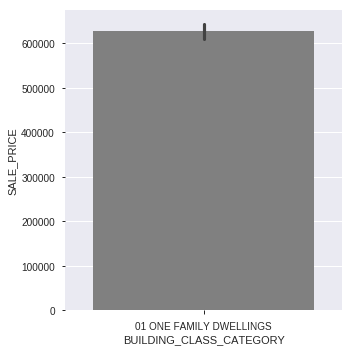

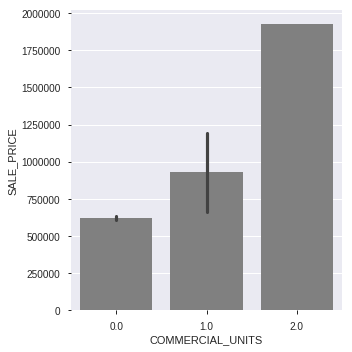

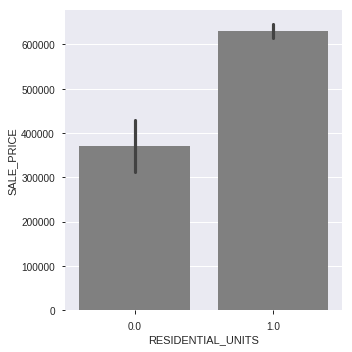

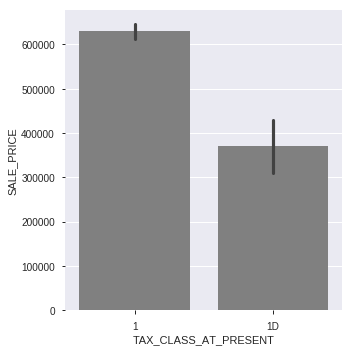

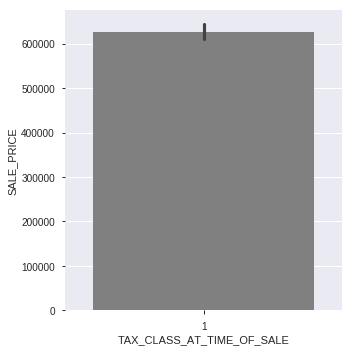

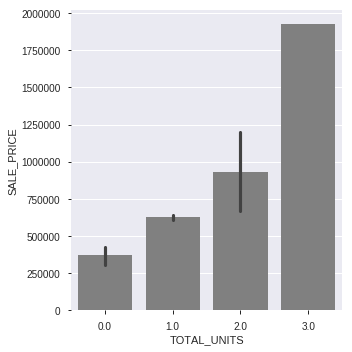

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

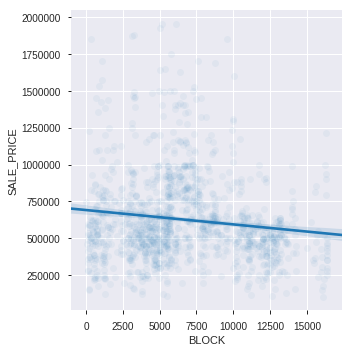

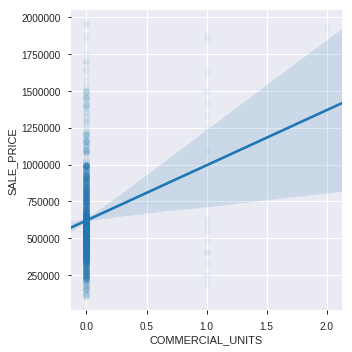

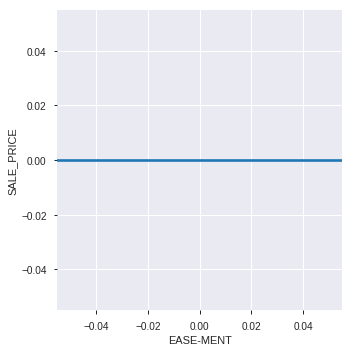

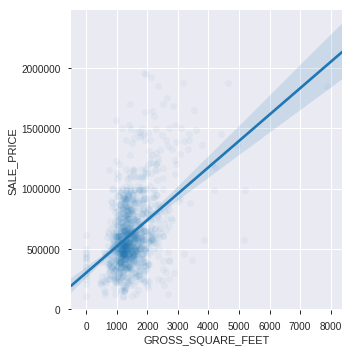

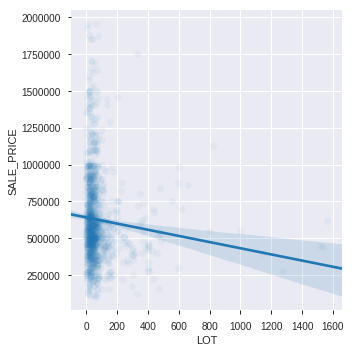

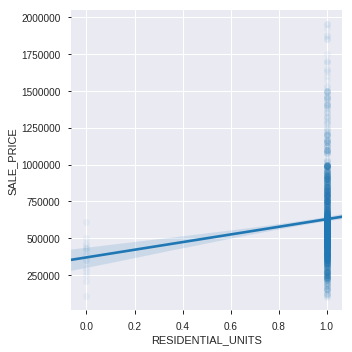

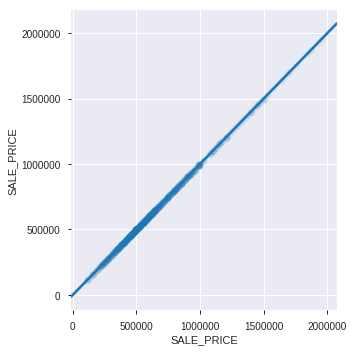

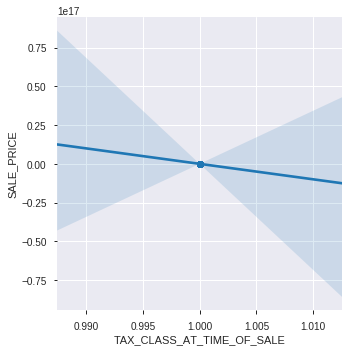

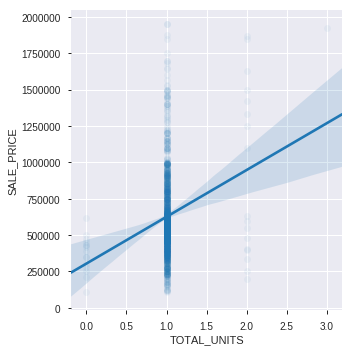

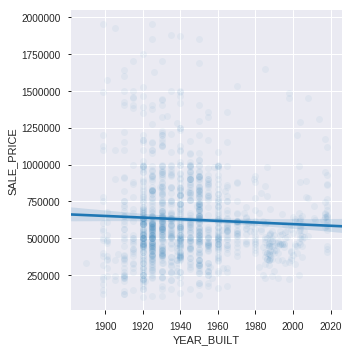

In [12]:
numeric=train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y="SALE_PRICE", data=train, scatter_kws=dict(alpha=.05))
  plt.show()

In [0]:
top10neighborhoods=train.NEIGHBORHOOD.value_counts()[:10].index
top10zips=train.ZIP_CODE.value_counts()[:10].index

train.loc[~train.NEIGHBORHOOD.isin(top10neighborhoods), "NEIGHBORHOOD"] = "OTHER"
test.loc[~test.NEIGHBORHOOD.isin(top10neighborhoods), "NEIGHBORHOOD"] = "OTHER"
validate.loc[~validate.NEIGHBORHOOD.isin(top10neighborhoods), "NEIGHBORHOOD"] = "OTHER"

train.loc[~train.ZIP_CODE.isin(top10zips), "ZIP_CODE"] = "OTHER"
test.loc[~test.ZIP_CODE.isin(top10neighborhoods), "ZIP_CODE"] = "OTHER"
validate.loc[~validate.ZIP_CODE.isin(top10neighborhoods), "ZIP_CODE"] = "OTHER"

In [14]:
train.NEIGHBORHOOD.value_counts()

OTHER                       952
ST. ALBANS                   37
FLUSHING-NORTH               37
QUEENS VILLAGE               32
SPRINGFIELD GARDENS          31
GREAT KILLS                  30
SO. JAMAICA-BAISLEY PARK     30
LAURELTON                    29
BAYSIDE                      26
FLATBUSH-EAST                24
MIDLAND BEACH                24
Name: NEIGHBORHOOD, dtype: int64

In [15]:
train.ZIP_CODE.value_counts()

OTHER      863
10312.0     60
10306.0     53
10314.0     51
11434.0     41
10305.0     34
10304.0     33
11413.0     33
11412.0     30
11234.0     29
10469.0     25
Name: ZIP_CODE, dtype: int64

In [0]:
target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number').columns.drop(target).tolist()
categoricals = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_categoricals = [col for col in categoricals
                               if train[col].nunique() <= 50]

features = numerics + low_cardinality_categoricals


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]
# target="SALE_PRICE"
# catagoricals=train.select_dtypes(exclude='number').columns.tolist
# numerics=train.select_dtypes("number").columns.drop(target).tolist()
# low_cardinality_catagoricals=[col for col in catagoricals if train[col].nunique() <= 50]

# features=numerics+low_cardinality_catagoricals

# x_train=train[features]
# y_train=train[target]
X_val=validate[features]
y_val=validate[target]
# x_test=test[features]
# y_test=test[target]

In [0]:
import category_encoders as ce 
from sklearn.preprocessing import StandardScaler

#catagorical_features=["TAX_CLASS_AT_PRESENT","BOROUGH"]
#numeric_features=numeric
#features=numeric_features+catagorical_features+['SALE_PRICE']

# x_train_subset=train[features]
# x_val_subset=validate[features]
# x_train_subset=x_train_subset.dropna()
# x_val_subset=x_val_subset.dropna()
# y_train=x_train_subset['SALE_PRICE']
# y_val=x_val_subset['SALE_PRICE']



In [0]:
# #x_val_subset.head()
# x_val_subset=x_val_subset.drop(columns="SALE_PRICE")
# x_train_subset=x_train_subset.drop(columns="SALE_PRICE")

In [0]:


encoder=ce.OneHotEncoder(use_cat_names=True)
X_train_encoded=encoder.fit_transform(X_train.drop(columns="EASE-MENT"))
X_val_encoded=encoder.transform(X_val.drop(columns="EASE-MENT"))

# scaler=StandardScaler()
# X_train_scaled=scaler.fit_transform(X_train_encoded)
# X_val_scaled=scaler.transform(X_val_encoded)

# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error

# model=LinearRegression()
# model.fit(X_train_scaled, y_train)
# y_pred=model.predict(X_val_scaled)
# mae=mean_absolute_error(y_val, y_pred)
# #from sklearn.metrics import accuracy_score
#accuracy_score=accuracy_score(y_val, y_pred)

In [0]:
#accuracy_score
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [0]:
# %matplotlib inline

# for col in sorted(train.columns):
#   if train[col].nunique()<30:
#     try:
#       sns.catplot(x=col,y="SALE_PRICE",data=train, kind=bar, color='purple')
#       plt.show
#     except:
#       pass

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

In [28]:

# train_numeric=train[numeric].drop(columns="SALE_PRICE")
# val_numeric=validate[numeric].drop(columns="SALE_PRICE")
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_val_scaled=scaler.transform(X_val_encoded)
for k in range(1, len(X_train_encoded.columns)+1):
  print (f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  x_train_selected=selector.fit_transform(X_train_scaled, y_train)
  x_val_selected=selector.transform(X_val_scaled)

  model=LinearRegression()
  model.fit(x_train_selected, y_train)
  y_pred=model.predict(x_val_selected)

  mae=mean_absolute_error(validate.SALE_PRICE,y_pred=y_pred)
  print(f'Test MAE: ${mae:.0f}\n')
  print(f"mae/ave_sale_price { mae/train.SALE_PRICE.mean() }")




1 features
Test MAE: $190921

mae/ave_sale_price 0.3046067571447865
2 features
Test MAE: $190214

mae/ave_sale_price 0.303478048890178
3 features
Test MAE: $190213

mae/ave_sale_price 0.3034772301799761
4 features
Test MAE: $188236

mae/ave_sale_price 0.3003220409685389
5 features
Test MAE: $196751

mae/ave_sale_price 0.3139085853377244
6 features
Test MAE: $198135

mae/ave_sale_price 0.3161165283777408
7 features
Test MAE: $195633

mae/ave_sale_price 0.31212467125316823
8 features
Test MAE: $185736

mae/ave_sale_price 0.29633458319575584
9 features
Test MAE: $184968

mae/ave_sale_price 0.2951081892297691
10 features
Test MAE: $179860

mae/ave_sale_price 0.2869589208807045
11 features
Test MAE: $165513

mae/ave_sale_price 0.2640692912660821
12 features
Test MAE: $164401

mae/ave_sale_price 0.2622946582781865
13 features
Test MAE: $163683

mae/ave_sale_price 0.2611496452929889
14 features
Test MAE: $163720

mae/ave_sale_price 0.2612087054635922
15 features
Test MAE: $163698

mae/ave_sal

In [0]:
train.SALE_PRICE.mean

 Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
 Do exploratory visualizations with Seaborn.
 Do one-hot encoding of categorical features.
 Do feature selection with SelectKBest.
 Fit a linear regression model with multiple features.
 Get mean absolute error for the test set.
 As always, commit your notebook to your fork of the GitHub repo.